In [30]:
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
df_red = pd.read_csv("winequality-red.csv", delimiter=";")
df_white = pd.read_csv("winequality-white.csv", delimiter=";")

V.1 Exploring the green reds

In [3]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    columns = wine_data.columns.values[:-1]
    fig, axes = plt.subplots(len(columns), len(columns), figsize=(17,17))

    x_greater = wine_data[wine_data["quality"] >= good_threshold] 
    x_less = wine_data[wine_data["quality"] <= bad_threshold]
    filtered_df = pd.concat([x_greater, x_less])
    t = [0 if el>=good_threshold else 1 for el in filtered_df["quality"]]

    for i, row_axes in enumerate(axes):
        for j, ax in enumerate(row_axes):
            if i == j:
                ax.text(0.2, 0.3, columns[i].replace(" ", "\n"), fontsize=13)
            else:
                ax.scatter(filtered_df[columns[i]], filtered_df[columns[j]], s=2, c=t, marker='*')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    if save_plot:
        plt.savefig('scatter_matrix.png', bbox_inches='tight')
    else:
        plt.show()

In [15]:
good_threshold = 8
bad_threshold = 3

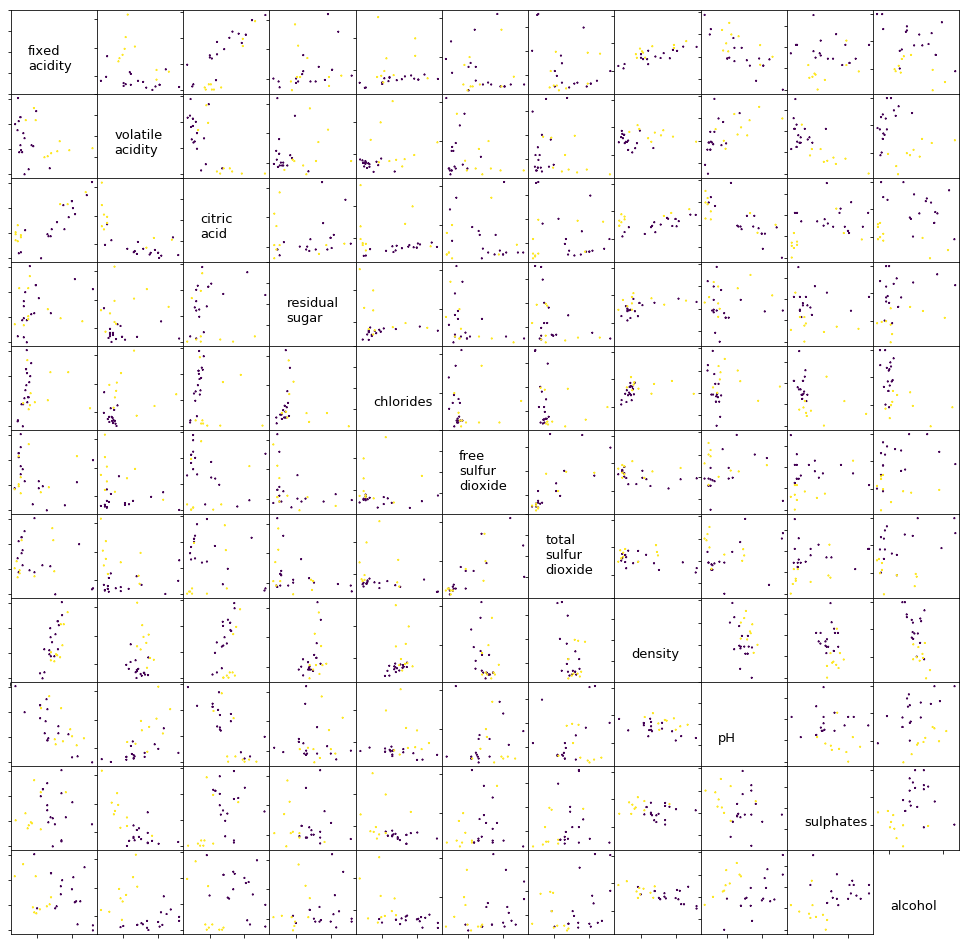

In [251]:
plot_scatter_matrix(df_red, good_threshold, bad_threshold, True)

V.2 Learning to perceptron

In [277]:
class Perceptron:
    def __init__(self):
        self.weights = [random.uniform(-1, 1) for _ in range(2)]
        self.bias = random.uniform(-1, 1)
        
        # correct bias and weights
        # bias = 21.91268798935518
        # weights = [-29.720712085212096, 7.4101446721024224]
        
    def predict(self, row):
        activation = self.bias
        for i in range(len(row)-1):
            activation += self.weights[i] * row[i]
        return 1.0 if activation >= 0.0 else 0.0
    
    def train(self, train_df, learning_rate, epochs):
        for epoch in range(epochs):
            sum_error = 0.0
            for index, row in train_df.iterrows():
                prediction = self.predict(row)
                error = row[-1] - prediction
                sum_error += error ** 2
                self.bias += learning_rate * error
                for i in range(len(self.weights)):
                    self.weights[i] += error * learning_rate * row[i]
            print('\repoch={0}, lrate={1}, error={2}'.format(epoch, learning_rate, sum_error), end='')
        print()

In [250]:
good_wine_df = df_red[df_red["quality"] >= good_threshold]
bad_wine_df = df_red[df_red["quality"] <= bad_threshold]
training_df = pd.concat([good_wine_df, bad_wine_df])
training_df["good"] = (training_df["quality"] >= good_threshold).astype(float)
training_df = training_df[["pH", "alcohol", "good",]]

In [278]:
perceptron = Perceptron()

In [283]:
perceptron.train(training_df, 0.05, 2000)
print(perceptron.weights, perceptron.bias)

epoch=1999, lrate=0.05, error=0.0
[-29.6617077391899, 7.406374623499976] 21.749195133973224


In [275]:
correct = 0
wrong = 0
for index, row in training_df.iterrows():
    prediction = perceptron.predict(row)
    correct = correct if prediction != float(row[-1]) else correct + 1
    wrong = wrong if prediction == float(row[-1]) else wrong + 1
    print("Expected: {0}, Predicted: {1}".format(row[-1], prediction))
    
print("correct:", correct, "wrong:", wrong)

Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 1.0, Predicted: 1.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
Expected: 0.0, Predicted: 0.0
correct: 28 wrong: 0
